Для дебага можно скопировать содержимое основной части encode.py, а в качестве args использовать закомментированный класс ниже

В качестве альтернативы можно исопльзовать named_tuple

In [1]:
# class args:
#     encoder_weights = 'weights/resnet_autoencoder_abs/encoder__resnet_autoencoder__512x16x16__upsample__B_6__63_epochs__last_relu__2023-06-08T05_56.pt'
#     encoder_name = 'encoder__resnet18__32x_512__relu_before_skipconncetion'
#     device = 'cpu'
#     B = 6
#     image_path = "compression-lab-imgs\\lena.png"
#     compressor_state_path: str = None
#     compressed_img_path: str = None
#     looseless_compressor_name = "huffman"

In [4]:
image_path = "compression-lab-imgs\\lena.png"
!python encode.py -i image_path -B 6 --compressed_img_path

In [2]:
from typing import List

def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result

def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)

In [3]:
# resnet_autencoder = create_resnet_autoencoder_abs(
#     resnet18(),
#     up_func_name = "upsample",
#     B=6,
#     last_decoder_activation = nn.ReLU())

# resnet_autencoder.load_state_dict(
#     torch.load("weights/resnet_autoencoder_abs/full__resnet_autoencoder__512x16x16__upsample__B_6__63_epochs__last_relu__2023-06-08T05_56.pt")
# )
# resnet_autencoder.eval()

# encoder_out, encoded = encoder_pipeline(resnet_autencoder.encoder, args.image_path, args.B, "a", "b")

# decoder = resnet_autencoder.decoder

In [5]:
decoder_in_channels = 512
up_func_name = "upsample"
last_decoder_activation = nn.ReLU()

decoder = SimpleResidualDecoder32x_ABS(
    decoder_in_channels,
    up_func_name = up_func_name,
    last_activation=last_decoder_activation)

decoder.load_state_dict(torch.load(
    "weights/resnet_autoencoder_abs/decoder__resnet_autoencoder__512x16x16__upsample__B_6__63_epochs__last_relu__2023-06-08T05_56.pt"))
decoder.eval()
None

In [6]:
from looseless_compressors import Huffman
h = Huffman(file_path = "a")

In [7]:
h

huffman:{49: '00000', 48: '00001', 34: '0001', 44: '0010', 38: '0011', 39: '0100', 43: '0101', 32: '011', 54: '1000000', 53: '1000001', 51: '100001', 47: '10001', 42: '1001', 40: '1010', 41: '1011', 33: '1100', 50: '110100', 55: '11010100', 63: '11010101000000', 61: '11010101000001', 60: '1101010100001', 59: '110101010001', 58: '11010101001', 57: '1101010101', 56: '110101011', 52: '1101011', 46: '11011', 36: '11100', 45: '11101', 35: '11110', 37: '11111'}

In [8]:
decoder_in_channels = 512
decoded_tensor_flat = torch.tensor(h.decode(encoded))
height = width =int((len(decoded_tensor_flat)/decoder_in_channels)**0.5)
decoded_tensor = decoded_tensor_flat.reshape(1, 512, height, width)

In [9]:
normalized_tensor = (decoded_tensor - 0.5) / 2**args.B

In [10]:
decoded_img = decoder(normalized_tensor.type(torch.float32))

In [11]:
np_decoded_img = denormalize_imagenet(decoded_img.squeeze(0)).cpu().detach().numpy()

In [12]:
import numpy as np
clipped = np.clip(np_decoded_img, 0, 1) 

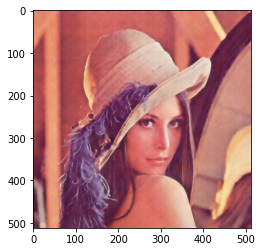

In [13]:
import matplotlib.pyplot as plt
plt.imshow(clipped.transpose(1,2,0))

In [49]:
import PIL

img = PIL.Image.open(args.image_path)
destination = f"{args.image_path}.jpg"
try:
    img.save(destination, "JPEG", quality=50, optimize=True, progressive=True)
except IOError:
    PIL.ImageFile.MAXBLOCK = img.size[0] * img.size[1]
    img.save(destination, "JPEG", quality=50, optimize=True, progressive=True)

In [50]:
import os
jpg_bytes = os.path.getsize(destination)*8

In [51]:
my_bytes/img_size, jpg_bytes/img_size

NameError: name 'my_bytes' is not defined

In [15]:
os.path.getsize('ENCODED')*8

192992

In [16]:
my_bytes

192990

In [17]:
def decode_binary_file(filename):
    with open(filename, 'rb') as f:
        binary_data = f.read()
    str_with_padding = ''.join(
        format(byte, '08b') for byte in binary_data)
    pad_end = str_with_padding.rfind('1')
    return str_with_padding[:pad_end]

In [18]:
decode_binary_file('ENCODED')[::-1]

'110101010111010101101010101011010101010101010101010101010101110101111010101010101011010101011010101010101010101010110101011101010101011010101010101010110110101101011101110101010101011011010101010111010101010101010101100010101110110110101101010101011011101010101101000101010101010111101010101101010111011010101101010101010101011011010110111010111011011011010111010110110110111011010111010111010101010101010101010101111011011011101101011111010101010111011101010110101101011110111111111011101111011110110101010101010111101111110101010110110101010111110101110111011110101010101010111010101010101010110111011111011010110101010111010110111110111101011011011111010101010101010101111110100101010101010101111011010101110101011011111011101010101010101011101101011101011111010101101011111110101101011101110101011110101101111111110101010111010101010101010101010110101110101011011010001010101010101010101010101010101010101101101101010101000001011010101101011010101010101010101010101010101010101010101110101010101

In [19]:
encoded_img[::-1]

'110101010111010101101010101011010101010101010101010101010101110101111010101010101011010101011010101010101010101010110101011101010101011010101010101010110110101101011101110101010101011011010101010111010101010101010101100010101110110110101101010101011011101010101101000101010101010111101010101101010111011010101101010101010101011011010110111010111011011011010111010110110110111011010111010111010101010101010101010101111011011011101101011111010101010111011101010110101101011110111111111011101111011110110101010101010111101111110101010110110101010111110101110111011110101010101010111010101010101010110111011111011010110101010111010110111110111101011011011111010101010101010101111110100101010101010101111011010101110101011011111011101010101010101011101101011101011111010101101011111110101101011101110101011110101101111111110101010111010101010101010101010110101110101011011010001010101010101010101010101010101010101101101101010101000001011010101101011010101010101010101010101010101010101010101110101010101

In [20]:
encoded_img == decode_binary_file('ENCODED')

True

In [21]:
decoded =h.decode(decode_binary_file('ENCODED'))

In [23]:
torch.all(out == decoded_tensor).item()

True

In [24]:
h

huffman:{4: '00', 3: '01', 2: '1'}

In [25]:
h.encoding = h.get_encoding_from_tree(h.root)

In [26]:
encoded_2 = h.encode(map(int, out.flatten()))

In [27]:
encoded_img == encoded_2

True

In [28]:
h.save_state_to_file("lena.json")

поставить 1 с конца, чтобы однозначно декодировать: убираем все биты с конца до первой единицы с конца включительно